## Курсовой проект

### Задача:
##### Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
### Наименование файлов с данными
##### course_project_train.csv - обучающий датасет
##### course_project_test.csv - тестовый датасет
### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Импорт модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from scipy.stats import probplot, mannwhitneyu, ttest_rel, boxcox, shapiro, chi2_contingency
    
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

### Функции

In [144]:
"""
            ГРАФИКИ
"""
def all_box(data):
    """
    Выведет боксплот для всех числовых признаков
    """
    sns.set(rc={"figure.figsize": (6, 4)})
    float_list = train_df.select_dtypes('float64').columns.tolist()
    for feature in float_list:
        sns.boxplot(data[feature])
        plt.show()
        
        
def hists_descr(feature, bins = 60, log_x = False, log_y = False, grid = False):
    """
    Строит гистограмму и кривую распределения по признаку
    """
    matplotlib.rcParams.update({'font.size' : 8})
    sns.set(rc={"figure.figsize": (12, 4)})
    plt.figure(figsize=(24,6))
    plt.subplot(121)
    feature.hist(bins=bins)
    plt.ylabel('Кол-во наблюдений')
    if log_x:
        plt.xscale(value = 'log')
    if log_y:
        plt.yscale(value = 'log')
    
    plt.subplot(122)
    ax1 = sns.distplot(feature)
    if log_x:
        ax1.set_xscale('log')
    if log_y:
        ax1.set_yscale('log')
    plt.show()
    

def box(num_feature,cat_feature, log_x = False, log_y = False):
    """
    Строит boxplot признака в разрезе целевой переменной
    """
    matplotlib.rcParams.update({'font.size' : 8})
    sns.set(rc={"figure.figsize": (10, 12)})
    target = train_df['Credit Default']
    temp = train_df[f'{cat_feature}'].astype('category')
    sns.boxplot(x = f'{num_feature}', y = temp, hue = target, data = train_df, orient = 'h', palette = 'Set1')
    
def cat_plot(data,feature,x = False, y = False, log_y = False, log_x = False):
    """
    Строит график распределения категориальных признаков в разрезе целевой переменной
    """
    sns.set(rc={"figure.figsize": (12, 4)})
    if x:
        ax = sns.countplot(x = feature, hue = 'Credit Default', data = data)
    if y:
        ax = sns.countplot(y = feature, hue = 'Credit Default', data = data)
    plt.ylabel('Кол-во')
    if log_y:
        ax.set_yscale('log')
    if log_x:
        ax.set_xscale('log')
    plt.show()
    
def plot_kde_qq_interval(data, feature):
    """
    Строит график плотности для признака в разрезе целевой переменной,
    qq диаграмму признака и доверительные интервалы в разрезе целевой переменной
    """
    
    sns.set(rc={"figure.figsize": (18, 12)})
    
    plt.subplot(221)
    sns.kdeplot(data[data['Credit Default'] == 1][feature],label='Погашен', color='green')
    sns.kdeplot(data[data['Credit Default'] == 0][feature],label='Просрочен', color='red')
    plt.xlabel(feature)
    plt.ylabel('Плотность распределения')
    plt.title(f'Распределение {feature} в разрезе целевой переменной')
    
    plt.subplot(222)
    probplot(data[feature].sample(1000), dist='norm', plot=plt)
    plt.title(f'QQ-диаграмма {feature}')
    plt.subplot(223)
    sns.pointplot(x='Credit Default', y=feature, data=data, capsize = .1)
    plt.title(f'Доверительные интервалы {feature}')
    
    plt.show()
    
def plot_qq(data,feature):
    """
    Строит ТОЛЬКО QQ-диаграмму по признаку
    """
    sns.set(rc={"figure.figsize": (10, 6)})
    probplot(data[feature].sample(1000), plot=plt)
    plt.title(f'QQ-диаграмма {feature}')
    plt.show()
    

"""
                ТЕСТЫ
"""    
def shapiro_samples(data, feature, samples_num, bxc = False):
    """
    Проверка распределения на нормальность по критерию Шапиро-Уилка с мощностью семплов 1000
    + обратное преобразование boxcox
    """
    shapiro_l = []
    boxcox_l = []
    for i in range(samples_num):
        spl = data[feature].sample(1000)
        c,p = shapiro(spl)
        shapiro_l.append(p)
        
        if bxc:
            x, y = boxcox(spl)
            c, p = shapiro(x)
            boxcox_l.append(p)
    
    if bxc:
        print(f'Среднее P-value по Shapiro с обратным преобразованием: {sum(boxcox_l)/len(boxcox_l)}')
        print(f'Среднее P-value по Shapiro без обратного преобразования: {sum(shapiro_l)/len(shapiro_l)}')
        print('Установленный нами порог α = 0,05')
    if not bxc:
        print(f'Среднее P-value по Shapiro: {sum(shapiro_l)/len(shapiro_l)}')
        print('Установленный нами порог α = 0,05')
        
def t_student(data, feature, samples_num):
    """
    Нахождение среднего p-value по t-критерию с мощностью семплов 1000
    """

    t_list = []
    for i in range(samples_num):
        spl_0 = data[data['Credit Default']==0][feature].sample(1000)
        spl_1 = data[data['Credit Default']==1][feature].sample(1000)
        
        c,p = ttest_rel(spl_0, spl_1)
        t_list.append(p)
        
    print(f'Среднее p-value по t-критерию Стьюдента равно: {sum(t_list)/len(t_list)}')
    print('Установленный нами порог α = 0,05')
    
    
def manna_uitny(data, feature, samples_num):
    """
    Нахождение среднего p-value по критерию Манна-Уитни с мощностью семплов 1000
    """

    m_list = []
    for i in range(samples_num):
        spl_0 = data[data['Credit Default']==0][feature].sample(1000)
        spl_1 = data[data['Credit Default']==1][feature].sample(1000)
        
        c,p = mannwhitneyu(spl_0, spl_1)
        m_list.append(p)
        
    print(f'Среднее p-value по критерию Манна-Уитни равно: {sum(m_list)/len(m_list)}')
    print('Установленный нами порог α = 0,05')
    
    
def chi2_cat_to_cat(data, feature, samples_num, all_info = False, interest_info = False):
    """
    Сопоставляет категории по chi2
    """
    categories_list_1 = data[feature].unique().tolist()
    categories_list_copy = categories_list_1
    for cat_1 in categories_list_1:
        for cat_2 in categories_list_copy:
            if cat_1 != cat_2:
                
                c_list = []
                p_list = []
                for i in range(samples_num):
                    
                    count_values = data.loc[data[feature] == cat_1, feature].count() + \
                    data.loc[data[feature] == cat_2, feature].count()
                    
                    if count_values < 400:
                        power = count_values
                    else:
                        power = 400
                    
                    spl = data.loc[data[feature].isin([cat_1,cat_2]),['Id',feature,'Credit Default']].sample(power)
                    table = spl.pivot_table(values = 'Id', index = feature, columns = 'Credit Default', aggfunc = 'count')
                    chi2, p, dof, expected = chi2_contingency(table, correction = False)
                    if not np.isnan(chi2):
                        c_list.append(chi2)
                        p_list.append(p)

                if all_info:
                    print(f'{cat_1}    -    {cat_2}')
                    try:
                        c_mean = sum(c_list)/len(c_list)
                        print(f'Среднее chi2 равно: {c_mean}\n' 
                              f'Среднее p-value равно: {sum(p_list)/len(p_list)}')
                        print('Установленный нами порог α = 0,05')
                        print('-'*43)
                    except:
                        print('Недостаточно данных')
                        print('-'*43)
                   
                if interest_info:
                    print('-'*43)
                    print(f'{cat_1}    -    {cat_2}')
                    try:
                        c_mean = sum(c_list)/len(c_list)
                        if c_mean < 0.05:
                            print(f'Среднее chi2 равно: {c_mean}\n' 
                                  f'Среднее p-value равно: {sum(p_list)/len(p_list)}')
                            print('Установленный нами порог α = 0,05')
                            print('-'*43)
                    except:
                        print('Недостаточно данных')
                        print('-'*43)
                        
def low_relevant_features(data):
    """
    Поиск признаков, у которых по меньшей мере 80% строк содержат одно значение
    """
    num_rows = len(data.index)
    low_information_cols = [] #

    for col in data.columns:
        cnts = data[col].value_counts(dropna=False)
        top_pct = (cnts/num_rows).iloc[0]
    
        if top_pct > 0.80:
            low_information_cols.append(col)
            print('{0}: {1:.5f}%'.format(col, top_pct*100))
            print(cnts)
            print()
                        
"""
        ЗАПОЛНЕНИЕ ПРОПУСКОВ, УДАЛЕНИЕ АНОМАЛИЙ
"""                        
                        
def fillna_annual_income(data):
    """
    Заполнение пропусков/аномалий в Annual Income
    """
    scores = data['Credit Score'].value_counts().index.to_list()
    for i in scores:
        temp = data.loc[data['Credit Score'] == i, 'Annual Income']
        data.loc[data['Annual Income'].isnull() & (data['Credit Score'] == i), 'Annual Income'] = temp.median()
    if np.isnan(temp.median()):
        data.loc[data['Annual Income'].isnull(), 'Annual Income'] = data['Annual Income'].median()
    data.loc[data['Annual Income'] > 3000000, 'Annual Income'] = data['Annual Income'].median()
        
"""def fillna_max_open_credit(data):
    if len(data[data['Maximum Open Credit'] == 0]) > 0:
        data.loc[data['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
        data.loc[data['Maximum Open Credit'] == 0, 'Current Loan Amount']
    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data.loc[data['Maximum Open Credit'] > 9000000, 'Current Loan Amount']
    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data['Maximum Open Credit'].median()"""
        
        
def fillna_max_open_credit(data):
    """
    Заполнение пропусков аномалий в Maximum Open Credit
    """
    if len(data[data['Maximum Open Credit'] == 0]) > 0:
        data.loc[data['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
        data['Maximum Open Credit'] = data['Maximum Open Credit'].fillna(data['Maximum Open Credit'].median)
    data.loc[data['Maximum Open Credit'] > 2000000, 'Maximum Open Credit'] = data['Maximum Open Credit'].median()
"""    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data.loc[data['Maximum Open Credit'] > 9000000, 'Current Loan Amount']
    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data['Maximum Open Credit'].median()      """  

def fillna_current_loan_amount(data):
    scores = data['Credit Score'].value_counts().index.to_list()
    for i in scores:
        temp = data.loc[data['Credit Score'] == i, 'Current Loan Amount']
        data.loc[data['Current Loan Amount'].isnull() & (data['Credit Score'] == i), 'Current Loan Amount'] = temp.median()
    if np.isnan(temp.median()):
        data.loc[data['Current Loan Amount'].isnull(), 'Annual Income'] = data['Current Loan Amount'].median()
    data.loc[data['Current Loan Amount'] > 3000000, 'Current Loan Amount'] = data['Current Loan Amount'].median()
    
        
def fillna_credit_score(data):
    """
    Корректирует значения > 1000, пропуски заменяет медиальным значением
    """
    score_list = data['Credit Score'].to_list()
    credit_list = []
    for i in score_list:
        if i > 1000:
            i = i / 10
            credit_list.append(i)
        else:
            credit_list.append(i)
    data.drop('Credit Score', axis = 1, inplace=True)
    data['Credit Score'] = credit_list
    data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].median())
    
def fillna_current_credit_balance(data):
    scores = data['Credit Score'].value_counts().index.to_list()
    for i in scores:
        temp = data.loc[data['Credit Score'] == i, 'Current Loan Amount']
        data.loc[data['Current Credit Balance'].isnull() & (data['Credit Score'] == i), 'Current Credit Balance'] = temp.median()
    if np.isnan(temp.median()):
        data.loc[data['Current Credit Balance'].isnull(), 'Annual Income'] = data['Current Credit Balance'].median()
    data.loc[data['Current Credit Balance'] > 1000000, 'Current Credit Balance'] = data['Current Credit Balance'].median()
    
def fillna_mountly_debt(data):
    scores = data['Credit Score'].value_counts().index.to_list()
    for i in scores:
        temp = data.loc[data['Credit Score'] == i, 'Current Loan Amount']
        data.loc[data['Monthly Debt'].isnull() & (data['Credit Score'] == i), 'Monthly Debt'] = temp.median()
    if np.isnan(temp.median()):
        data.loc[data['Monthly Debt'].isnull(), 'Monthly Debt'] = data['Monthly Debt'].median()
    data.loc[data['Monthly Debt'] > 60000, 'Monthly Debt'] = data['Monthly Debt'].median()
    
def years_cat_to_num(data):
    data.replace({'Years in current job':
                  {'< 1 year': 0,
                   '1 year': 1,
                   '2 years': 2, 
                   '3 years': 3,
                   '4 years': 4,
                   '5 years': 5,
                   '6 years': 6,
                   '7 years': 7,
                   '8 years': 8,
                   '9 years': 9,
                   '10+ years': 10}}, inplace=True)
    
def data_discharge_editor(data):
    """
    Удаляет аномалии по интреквантильному размаху
    """
    #float_list = train_df.select_dtypes('float64').columns.tolist()
    float_list = ['Annual Income','Maximum Open Credit','Current Loan Amount','Current Credit Balance','Monthly Debt']
    for feature in float_list:
        Q1 =  data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        dell = train_df[(data[feature] < Q1-1.5*IQR ) | (data[feature] > Q3+1.5*IQR)].index.tolist()
        data.drop(dell, inplace = True)

### Преобразование датасетов

In [111]:
test_df = pd.read_csv('course_project_test.csv')
test_df['Id'] = test_df.index.tolist()

## 1.Анализ данных

In [112]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,2
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,3
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,4


In [113]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [114]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000,2500.00000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860,1249.50000
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442,721.83216
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,0.00000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000,624.75000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000,1249.50000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000,1874.25000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,2499.00000


## 2.Предварительный анализ количественных данных и заполнение пропусков

### Первым я обработаю Credit Score по соображениям дальнейшей подгонки относительно него

### 2.1 Credit Score

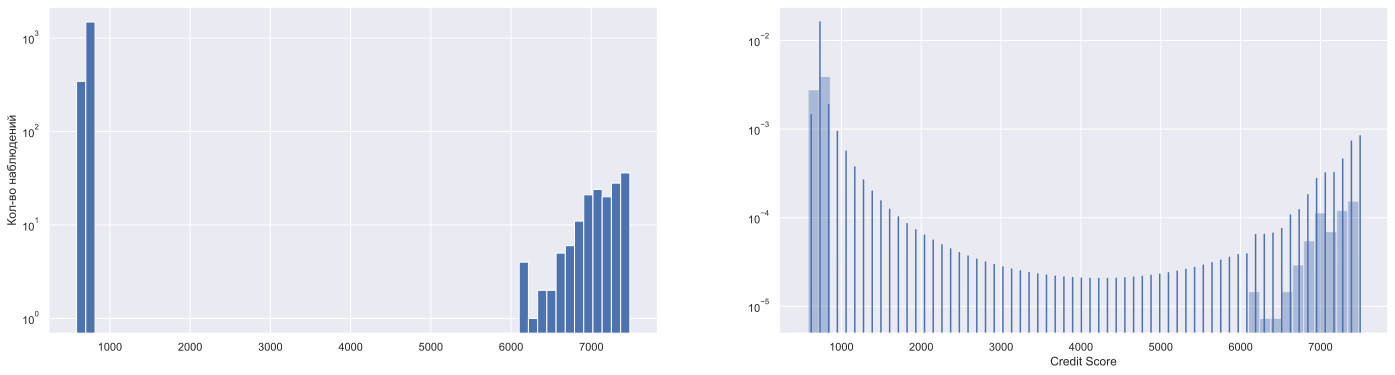

In [115]:
hists_descr(test_df['Credit Score'], log_y=True)

In [116]:
fillna_credit_score(test_df)

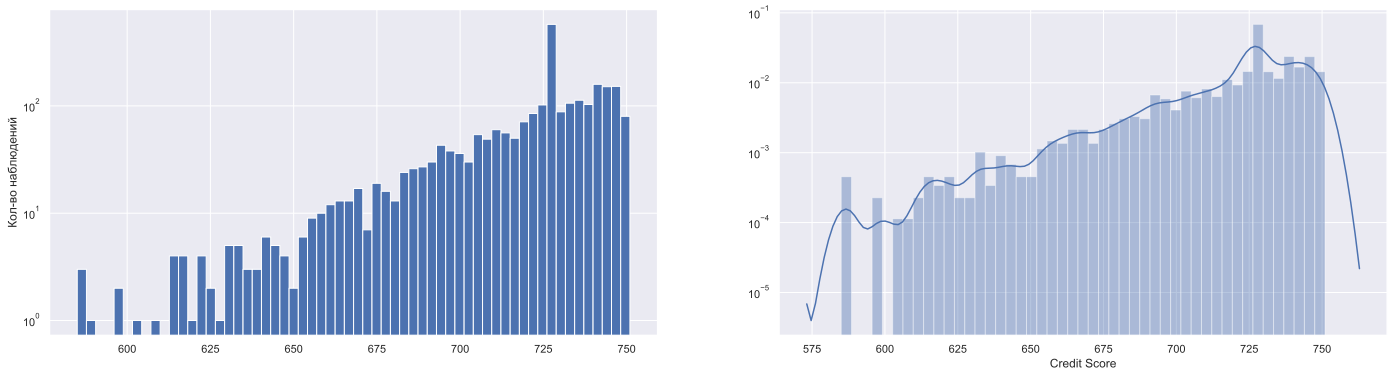

In [117]:
hists_descr(test_df['Credit Score'], log_y=True)

### 2.1.Annual Income

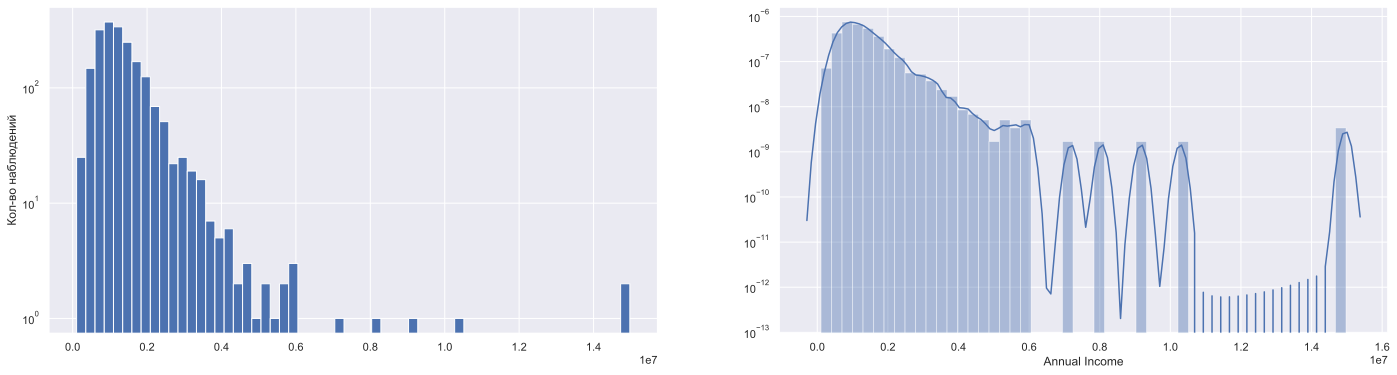

In [118]:
hists_descr(test_df['Annual Income'],log_y = True)

###### Ищем пропущенные значения

In [119]:
test_df['Annual Income'].isnull().value_counts()

False    1987
True      513
Name: Annual Income, dtype: int64

Замена пропусков медиальным значением по цели кредита

In [120]:
fillna_annual_income(test_df)

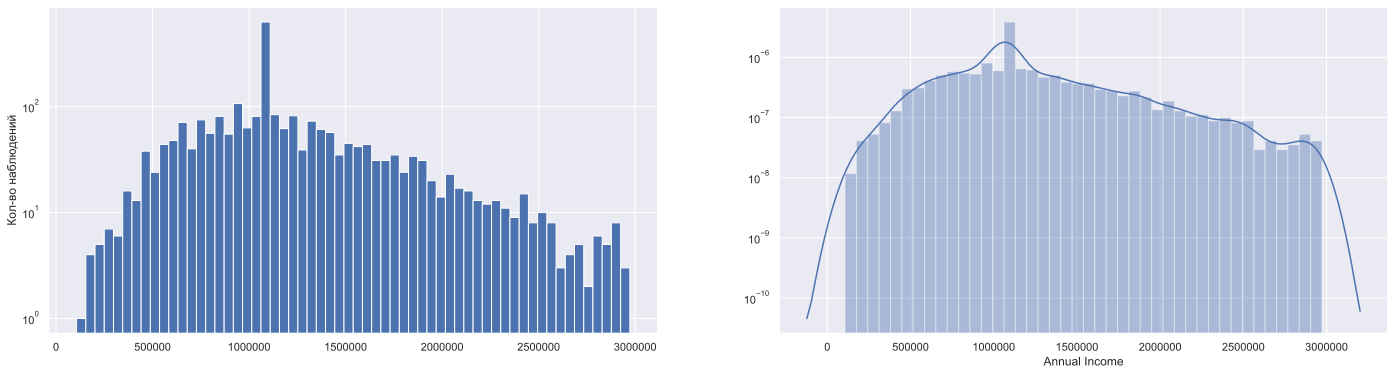

In [121]:
hists_descr(test_df['Annual Income'],log_y = True)

### 2.2.Tax Liens

In [122]:
test_df['Tax Liens'].isnull().value_counts() # пропусков нет
test_df['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

### 2.3.Number of Open Accounts

In [123]:
test_df['Number of Open Accounts'].isnull().value_counts() # пропусков нет
test_df['Number of Open Accounts'].value_counts()

9.0     245
8.0     223
10.0    218
11.0    211
12.0    204
6.0     183
13.0    178
7.0     176
14.0    159
5.0     106
15.0     97
16.0     81
17.0     66
4.0      63
18.0     52
19.0     46
20.0     37
21.0     29
3.0      29
22.0     26
23.0     17
27.0     10
24.0      9
2.0       7
30.0      6
25.0      6
26.0      5
28.0      3
33.0      2
48.0      1
31.0      1
1.0       1
36.0      1
29.0      1
34.0      1
Name: Number of Open Accounts, dtype: int64

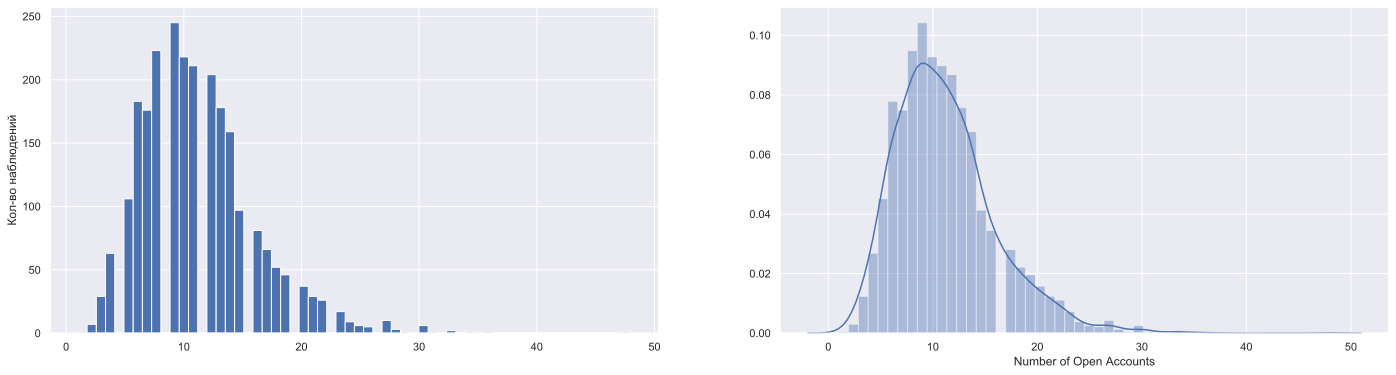

In [124]:
hists_descr(test_df['Number of Open Accounts'])

### 2.4.Years of Credit History

Пропусков нет, аномальных значений нет

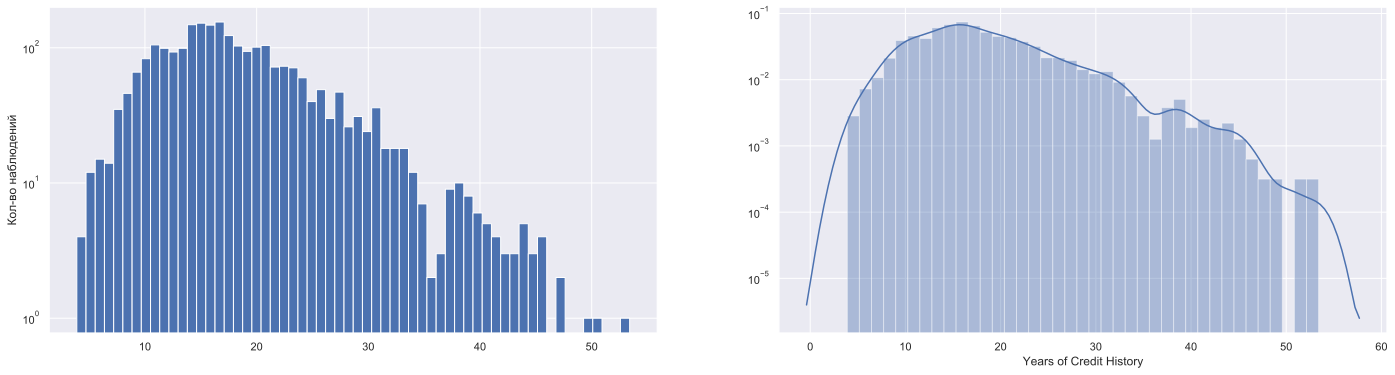

In [125]:
hists_descr(test_df['Years of Credit History'], log_y=True)

### 2.5.Number of Credit Problems

In [126]:
test_df['Number of Credit Problems'].isnull().value_counts() # пропусков нет
test_df['Number of Credit Problems'].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

### 2.6.Maximum Open Credit

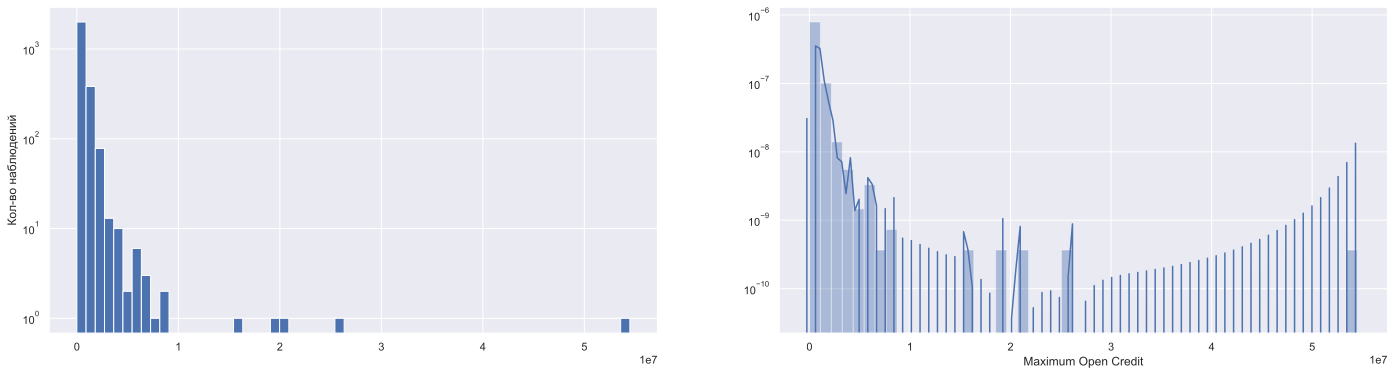

In [127]:
hists_descr(test_df['Maximum Open Credit'], log_y = True)

In [128]:
fillna_max_open_credit(test_df)

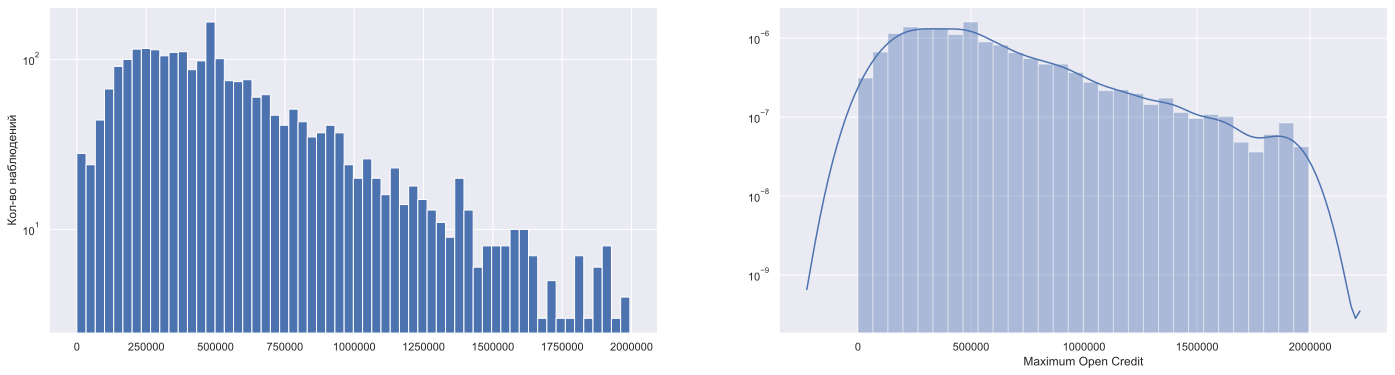

In [129]:
hists_descr(test_df['Maximum Open Credit'], log_y = True)

Пока будем считать, что такое распредеделение величины нас устраивает

### 2.7.Months since last delinquent...........UPD(удален)

In [130]:
test_df['Months since last delinquent'].isnull().value_counts()

True     1358
False    1142
Name: Months since last delinquent, dtype: int64

Я не знаю что делать с этим признаком,подчти половина значений пропущенно и он слишком привязан к ситуации конкретного объекта.У меня нет идей как искуственно заменить его. Пока решаю не использовать его при построении модели.

In [131]:
test_df.drop('Months since last delinquent', axis = 1, inplace=True)

### 2.8.Bankruptcies

In [132]:
test_df['Bankruptcies'].isnull().value_counts()

False    2497
True        3
Name: Bankruptcies, dtype: int64

Пропуски заменим на нулевую моду

In [133]:
test_df['Bankruptcies'].mode()[0]

0.0

In [134]:
test_df['Bankruptcies'].fillna(0, inplace=True)

### 2.9.Current Loan Amount

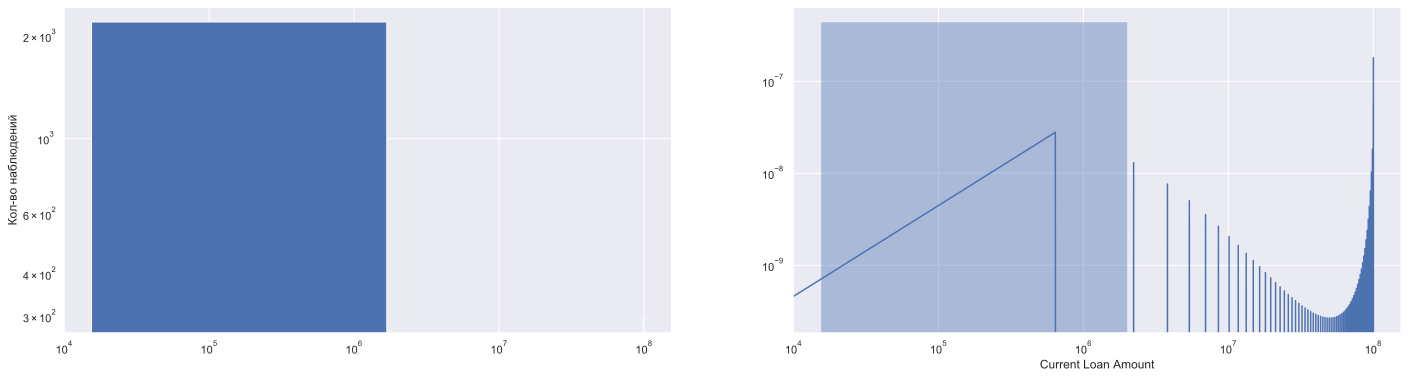

In [135]:
hists_descr(test_df['Current Loan Amount'],log_x=True, log_y=True)

In [136]:
test_df['Current Loan Amount'].describe()

count    2.500000e+03
mean     1.215572e+07
std      3.226097e+07
min      1.542200e+04
25%      1.871265e+05
50%      3.223660e+05
75%      5.225825e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [71]:
# len(test_df[test_df['Current Loan Amount'] >= 99999999]) - 297 значений
test_df[test_df['Current Loan Amount'] >= 99999999]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id
17,Home Mortgage,1246495.0,9 years,0.0,10.0,22.9,357456.0,0.0,0.0,debt consolidation,Short Term,99999999.0,294823.0,21086.0,729.0,17
22,Own Home,960735.0,8 years,0.0,17.0,11.8,512380.0,0.0,0.0,debt consolidation,Short Term,99999999.0,164179.0,17133.0,733.0,22
33,Rent,743888.0,1 year,0.0,11.0,20.0,927124.0,0.0,0.0,debt consolidation,Short Term,99999999.0,303468.0,15002.0,735.0,33
45,Home Mortgage,1768729.0,10+ years,0.0,11.0,19.7,3462558.0,0.0,0.0,debt consolidation,Short Term,99999999.0,1764321.0,29184.0,737.0,45
59,Rent,1984512.0,5 years,0.0,11.0,10.5,286088.0,0.0,0.0,debt consolidation,Short Term,99999999.0,134653.0,25964.0,745.0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,Rent,5997920.0,2 years,0.0,11.0,17.6,1178584.0,0.0,0.0,debt consolidation,Short Term,99999999.0,350151.0,39686.0,750.0,2444
2457,Home Mortgage,1437502.0,10+ years,0.0,16.0,13.0,750970.0,1.0,1.0,debt consolidation,Short Term,99999999.0,71991.0,25396.0,747.0,2457
2461,Rent,613225.0,3 years,0.0,6.0,16.8,188078.0,0.0,0.0,other,Short Term,99999999.0,13319.0,7665.0,749.0,2461
2467,Home Mortgage,939075.0,4 years,0.0,21.0,16.7,577940.0,0.0,0.0,debt consolidation,Short Term,99999999.0,269534.0,17216.0,737.0,2467


Попробую заменить на Maximum Open Credit

In [137]:
fillna_current_loan_amount(test_df)

Посмотрим, что получилось

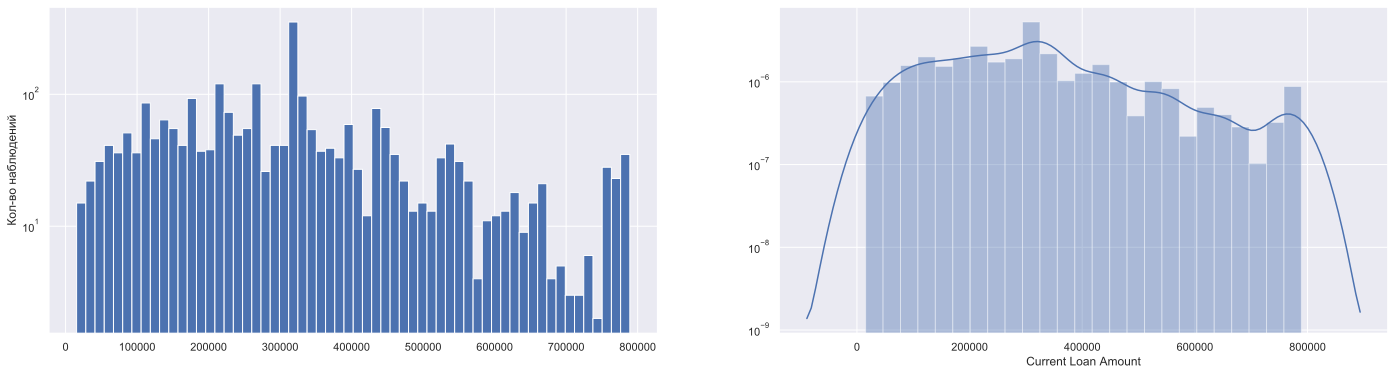

In [138]:
hists_descr(test_df['Current Loan Amount'], log_y=True)

### 2.10.Current Credit Balance

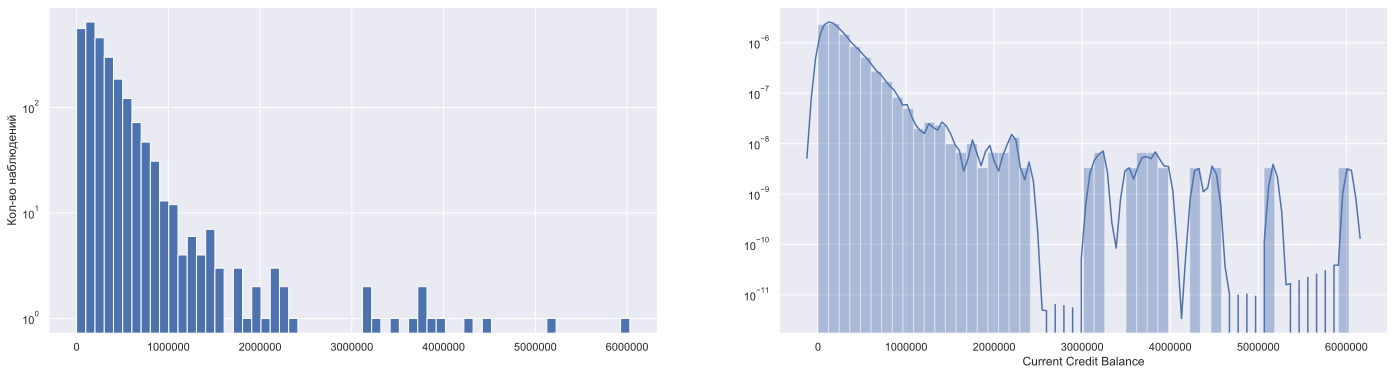

In [139]:
hists_descr(test_df['Current Credit Balance'], log_y=True)

In [141]:
fillna_current_credit_balance(test_df)

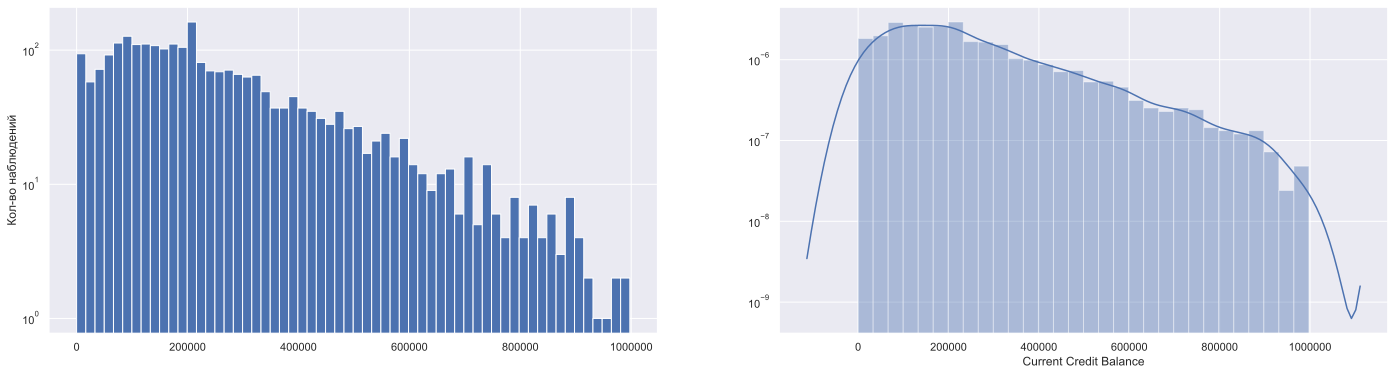

In [142]:
hists_descr(test_df['Current Credit Balance'], log_y=True)

### 2.11.Monthly Debt

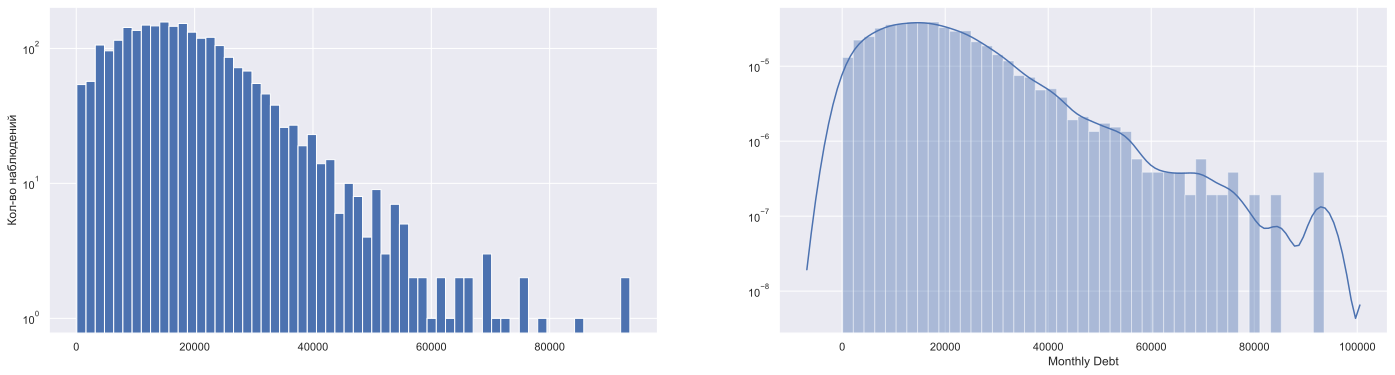

In [143]:
hists_descr(test_df['Monthly Debt'], log_y=True)

In [145]:
fillna_mountly_debt(test_df)

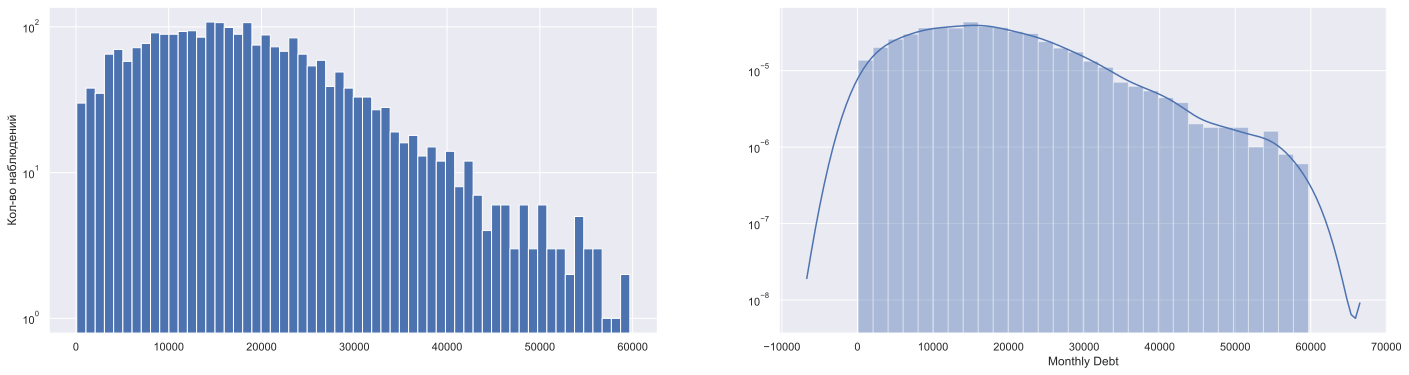

In [146]:
hists_descr(test_df['Monthly Debt'], log_y=True)

## 3.Предварительный анализ категориальных данных и заполнение пропусков

### 3.1.Home Ownership

In [147]:
test_df['Home Ownership'].isnull().value_counts() # пропусков нет
test_df['Home Ownership'].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

### 3.2.Years in current job

In [148]:
test_df['Years in current job'].isnull().value_counts()

False    2414
True       86
Name: Years in current job, dtype: int64

In [149]:
test_df['Years in current job'].mode()

0    10+ years
dtype: object

Заполним пропуски модой

In [150]:
test_df['Years in current job'].fillna('10+ years', inplace=True)

In [151]:
years_cat_to_num(test_df)

### 3.3.Purpose

In [153]:
test_df['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

### 3.4.Term

In [154]:
test_df['Term'].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

Пропусков нет

### Посмотрим на корреляционную матрицу

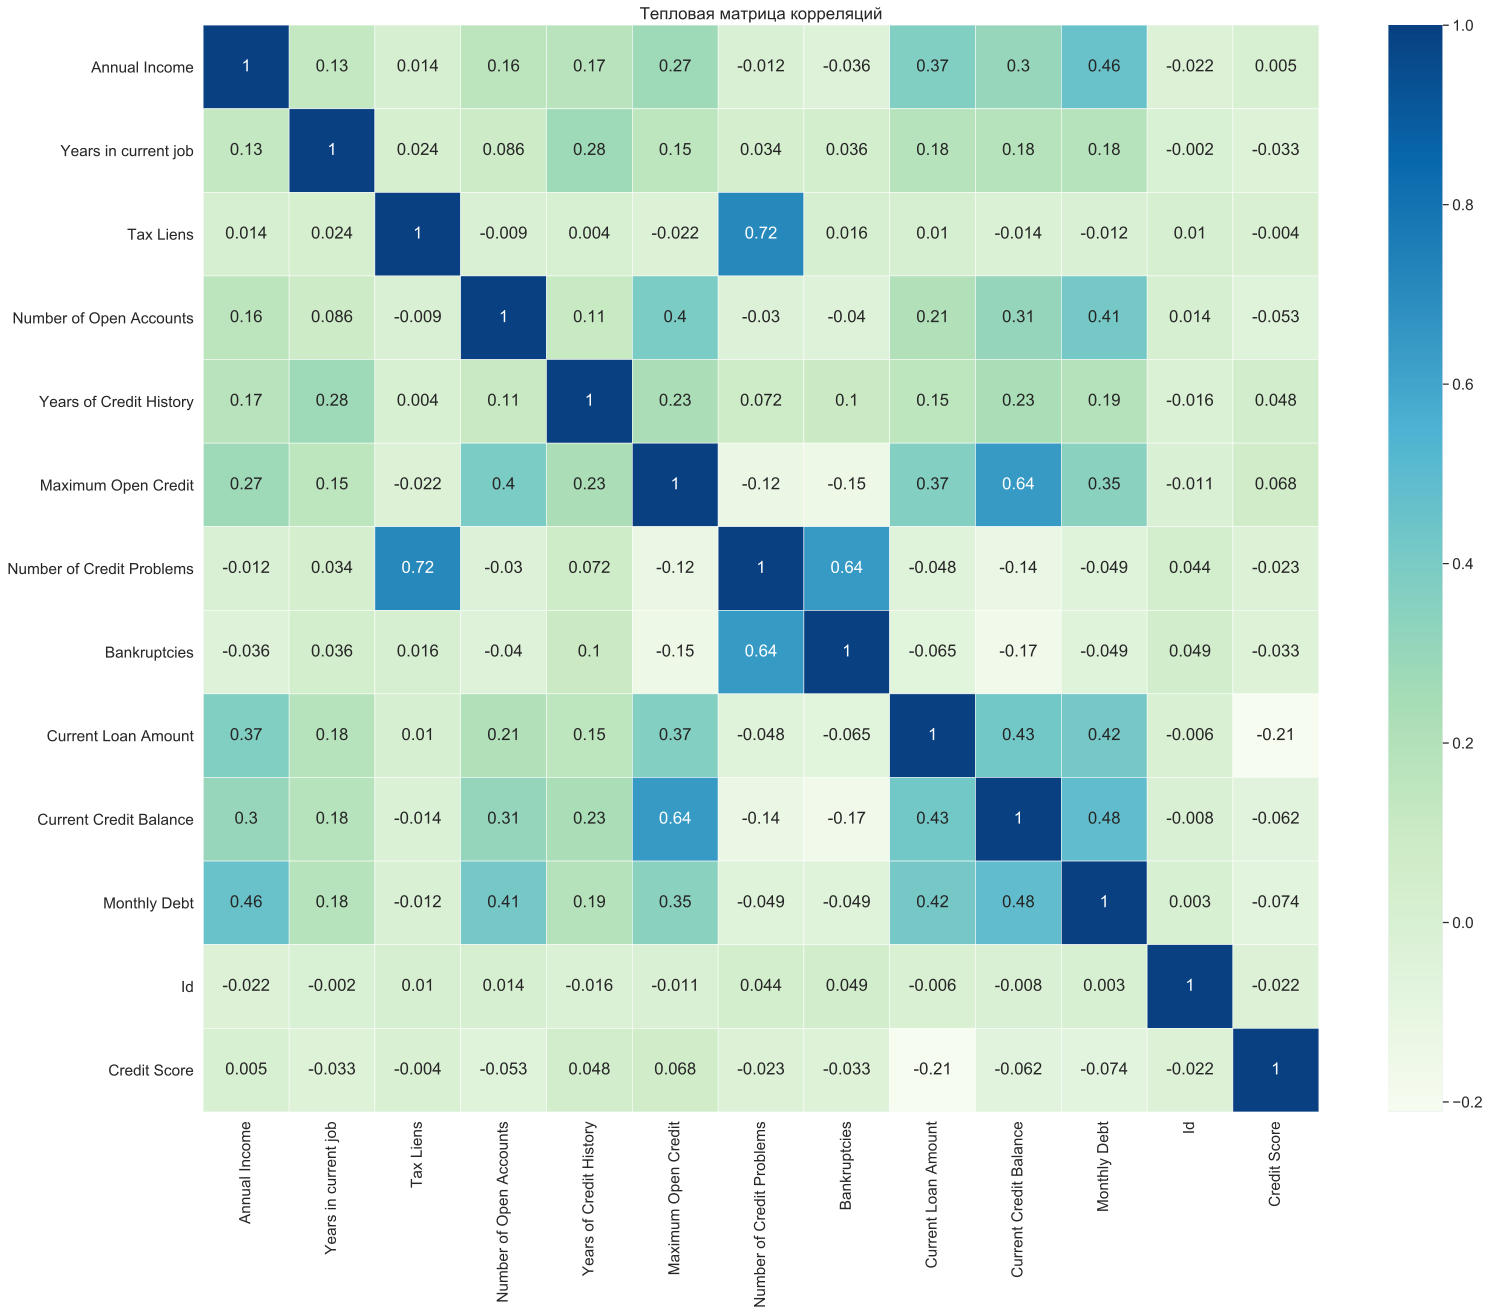

In [155]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(test_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

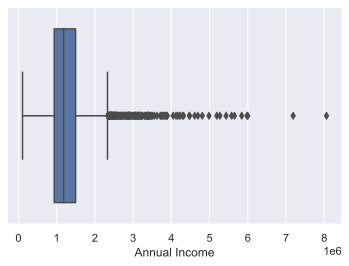

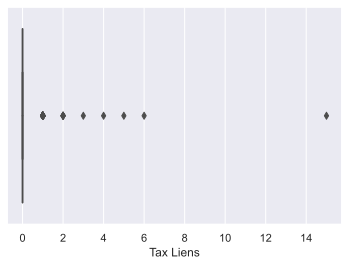

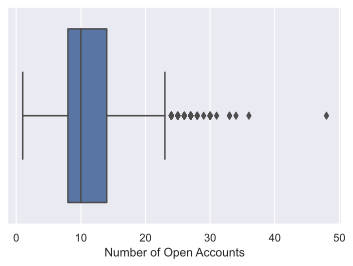

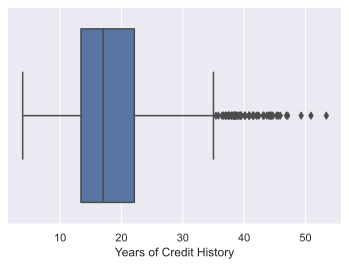

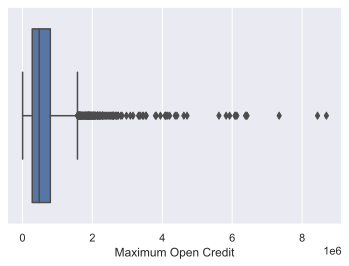

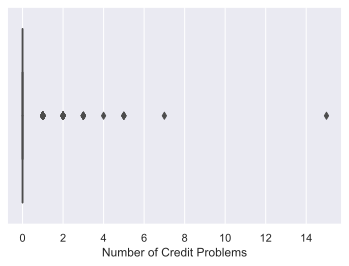

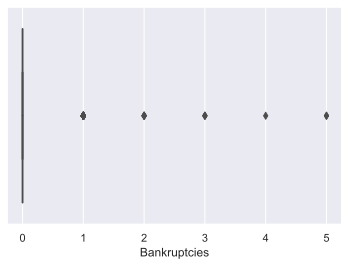

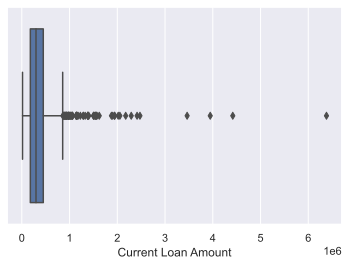

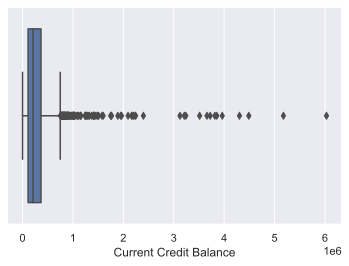

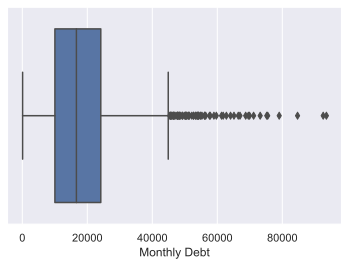

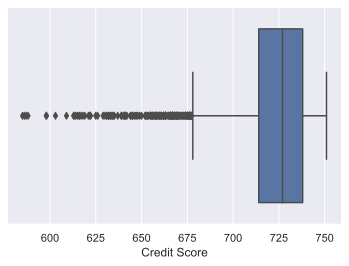

In [89]:
all_box(test_df)

## Финальное преобразование признаков

### Приведение типов

In [ ]:
cat_colls = ['Home Ownership','Purpose','Term','Years in current job']
for coll in cat_colls:
    train_df[coll] = pd.Categorical(train_df[coll])

## Преобразование категориальных данных в бинарные и сохранение датасетов

In [90]:
colls = ['Home Ownership','Years in current job','Purpose', 'Term']
#train_df = train_df.replace('Short Term',0)
#train_df = train_df.replace('Long Term',1)
test_final = pd.get_dummies(test_df,columns = colls)
test_final.rename(columns = {'Years in current job_< 1 year' : 'Years in current job less 1 year',
                          'Years in current job_10+ years' : 'Years in current job more 10 years'}, inplace=True)
test_final.to_csv("test_dummies.csv", index=False)
test_df.to_csv("test_prepared.csv", index = False)

Сконтатенируем наши категориальные признаки по раннее сделанному анализу

### Home Ownership

In [91]:
test_final['Home Ownership_2'] = test_final['Home Ownership_Have Mortgage']
test_final['Home Ownership_1'] = [a + b + c for a,b,c in zip(test_final['Home Ownership_Home Mortgage'], 
                                                              test_final['Home Ownership_Own Home'],
                                                              test_final['Home Ownership_Rent']
                                                             )]

### Purpose

In [92]:
test_final['Purpose_1'] = test_final['Purpose_wedding']
test_final['Purpose_2'] = [a + b + c + d for a,b,c,d in zip(test_final['Purpose_vacation'],
                                                             test_final['Purpose_educational expenses'],
                                                             test_final['Purpose_moving'],
                                                             test_final['Purpose_buy house']
                                                             )]
test_final['Purpose_3'] = [q+w+e+r+t+y+u+i+o for q,w,e,r,t,y,u,i,o in zip(test_final['Purpose_debt consolidation'],
                                                                          test_final['Purpose_other'],
                                                                          test_final['Purpose_home improvements'],
                                                                          test_final['Purpose_take a trip'],
                                                                          test_final['Purpose_buy a car'],
                                                                          test_final['Purpose_small business'],
                                                                          test_final['Purpose_business loan'],
                                                                          test_final['Purpose_medical bills'],
                                                                          test_final['Purpose_major purchase'])]

In [93]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   float64
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   float64
 6   Bankruptcies                  2500 non-null   float64
 7   Current Loan Amount           2500 non-null   float64
 8   Current Credit Balance        2500 non-null   float64
 9   Monthly Debt                  2500 non-null   float64
 10  Id                            2500 non-null   int64  
 11  Credit Score                  2500 non-null   float64
 12  Home Ownership_Have Mortgage  2500 non-null   uint8  
 13  Hom

In [94]:
test_final.drop(['Purpose_vacation','Purpose_buy a car','Purpose_buy house','Purpose_debt consolidation',
                  'Purpose_educational expenses','Purpose_home improvements','Purpose_major purchase',
                 'Purpose_medical bills','Purpose_moving','Purpose_other','Purpose_small business','Purpose_take a trip',
                 'Purpose_vacation','Purpose_wedding','Purpose_business loan','Home Ownership_Have Mortgage','Home Ownership_Home Mortgage',
                 'Home Ownership_Own Home','Home Ownership_Rent'], axis = 1, inplace = True)

In [95]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              2500 non-null   float64
 1   Tax Liens                  2500 non-null   float64
 2   Number of Open Accounts    2500 non-null   float64
 3   Years of Credit History    2500 non-null   float64
 4   Maximum Open Credit        2500 non-null   float64
 5   Number of Credit Problems  2500 non-null   float64
 6   Bankruptcies               2500 non-null   float64
 7   Current Loan Amount        2500 non-null   float64
 8   Current Credit Balance     2500 non-null   float64
 9   Monthly Debt               2500 non-null   float64
 10  Id                         2500 non-null   int64  
 11  Credit Score               2500 non-null   float64
 12  Years in current job_0     2500 non-null   uint8  
 13  Years in current job_1     2500 non-null   uint8

## Приведение типов

In [96]:
NUM_FEATURES = ['Annual Income','Number of Open Accounts','Bankruptcies','Years of Credit History','Maximum Open Credit',
               'Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score','Tax Liens','Number of Credit Problems']
CAT_FEATURES = ['Home Ownership_1','Home Ownership_2','Purpose_1','Purpose_2','Purpose_3',
                'Term_Long Term','Term_Short Term','Years in current job_0','Years in current job_10','Years in current job_2',
               'Years in current job_3','Years in current job_4','Years in current job_5',
               'Years in current job_6','Years in current job_7','Years in current job_8',
                'Years in current job_9','Years in current job_1']

for dig_col in NUM_FEATURES:
    test_final[NUM_FEATURES] = test_final[NUM_FEATURES].astype('int64')

for cat_col in CAT_FEATURES:
    test_final[cat_col] = pd.Categorical(test_final[cat_col])


KeyError: 'Years in current job_1 year'

In [ ]:
test_final.info()

Сохраним датасет

In [ ]:
test_final.to_csv("test_dummies_prepared.csv", index=False)